## Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## План работы

1. [Открытие данных](#start)
2. [Предобработка данных](#preprocessing)
3. [Исследовательский анализ данных](#analysis)
4. [Портрет пользователя каждого региона](#portrait)
5. [Проверка гипотез](#hypothesis)
6. [Общий вывод](#conclusion)

## Открытие данных <a id="start"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns

In [2]:
data = pd.read_csv("/datasets/games.csv")
display(data.sample(10))
data.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
6804,Genma Onimusha,XB,2002.0,Action,0.14,0.04,0.05,0.01,83.0,8.6,M
559,LEGO Star Wars II: The Original Trilogy,PS2,2006.0,Action,1.85,0.64,0.01,0.19,84.0,9,E10+
8416,Wolfenstein 3D,GBA,2002.0,Shooter,0.12,0.04,0.00,0.00,57.0,6,M
7744,J-League Jikkyou Winning Eleven 3,PS,1997.0,Sports,0.00,0.00,0.18,0.01,NaN,NaN,NaN
16372,Curse of the Amsterdam Diamond,DS,2012.0,Puzzle,0.00,0.01,0.00,0.00,NaN,NaN,NaN
4895,Are You Smarter than a 5th Grader? Make the Grade,DS,2008.0,Misc,0.36,0.00,0.00,0.03,NaN,tbd,E
12357,GunGriffon II,SAT,1998.0,Simulation,0.00,0.00,0.06,0.00,NaN,NaN,NaN
7525,The Bible Game,PS2,2005.0,Misc,0.10,0.08,0.00,0.03,NaN,5.4,E
3803,Batman: Arkham City,PC,2011.0,Action,0.16,0.28,0.00,0.09,91.0,8.6,T
2134,Medal of Honor: Underground,PS,2000.0,Shooter,0.54,0.37,0.00,0.06,86.0,9,T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Вывод

На первый взгляд я заметил, что нужно удалить две строки, где пропущенны имя игры. Пропуски в годах я предлагаю оставить, т.к. мы точно не можем сказать, когда именно вышла игра, мы конечно можем опереться на то, что одна и та же игра выходила на разных платформах в один и тот же год, но возможно и обратное, также это может быть ремастертед и т.п., плюс этих пропусков достаточно мало. А также мы имеем обилие пропусков в оценке игр и их рейтинге, их нужно будет рассмотреть досконально. И заменить в некоторых данных их тип.

## Предобработка данных <a id="preprocessing"></a>

In [3]:
#Приводим к нижнему регистру названия столбцов
data.columns = data.columns.str.lower()
#Удаляем строки с пропущенными значениями в столбце year_of_release
data.dropna(subset = ['year_of_release'], inplace = True)
#Удаляем строки, где пропущены значения в имени игры
data.dropna(subset = ['name'], inplace = True)

In [4]:
data.duplicated().sum() #Дубликаты отсутствуют

0

In [5]:
#заменим тип данных в годах релиза
data['year_of_release'] = data['year_of_release'].astype('Int64')

In [6]:
data['user_score'].value_counts() 

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
0.9       2
0.5       2
9.6       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

Обнаружены 2424 cтроки со значение tbd, что значит to be determined, т.е. эти строки специально не заполнили, скорее всего из-за отсуствия или малого кол-ва оценок пользователей, след-но мы можем заменить это аббревиатуру на NaN.

In [7]:
#Заменим tbd на NaN
data['user_score'] = data['user_score'].replace('tbd', np.nan)
#Теперь можем поменять тип данных
data['user_score'] = data['user_score'].astype(float)

Посчитаем суммарные продажи во всех регионах

In [8]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


### Вывод

В предобработке данных мы привели тип данных к более корректным (год релиза и оценку критиков к целочисленному, оценку пользователей к вещественному). Также проверили наличие дубликатов. Удалили 2 строки, где пропущено название игры. Привели названия столбцов к нижнему регистру. И создали столбец, в котором посчитали суммарные продажи по всем регионам. 

## Исследовательский анализ данных <a id="analysis"></a>

Cтроим график выпуска игр по годам

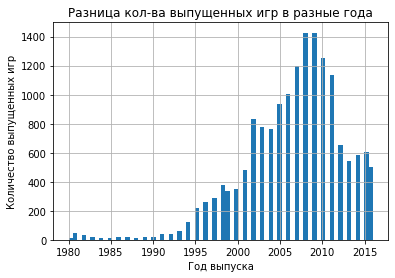

In [9]:
data['year_of_release'].plot(kind = 'hist', bins = 70, grid = True)
plt.title("Разница кол-ва выпущенных игр в разные года")
plt.xlabel("Год выпуска")
plt.ylabel("Количество выпущенных игр")
plt.show()

Можно заметить, что большая часть игр продавалось с 2002 года.

#### Определим платформы с наибольшими продажами

In [10]:
platforms = data.pivot_table(index = 'platform', 
                             values = 'total_sales', 
                             aggfunc = 'sum').sort_values(by = 'total_sales', ascending = False)
platforms_top = platforms.head(6).reset_index().rename_axis(None, axis=1)
platforms_dict = platforms_top['platform'].unique()
platforms_top

,platform,total_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78
5,PS,727.58


#### Построим распределение по годам

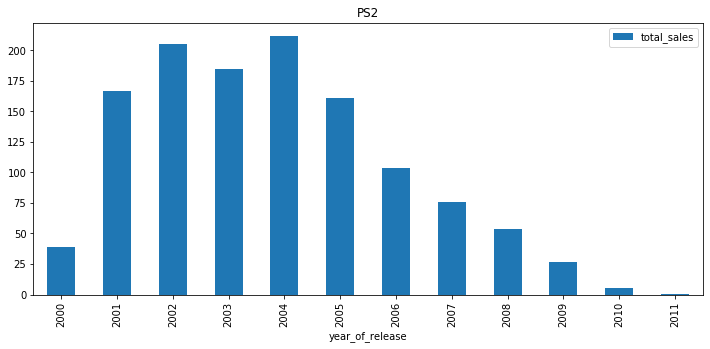

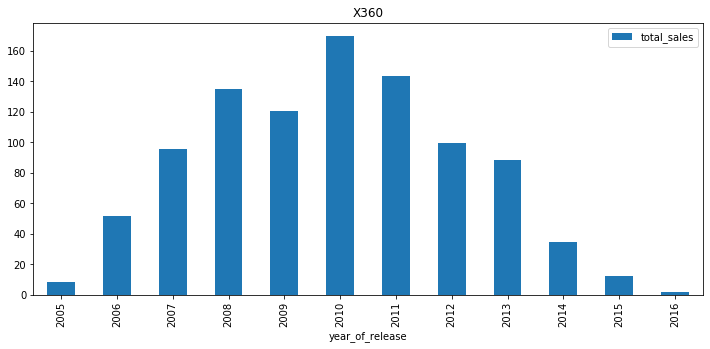

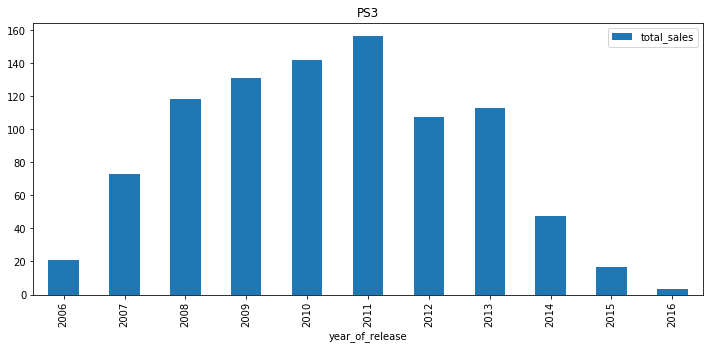

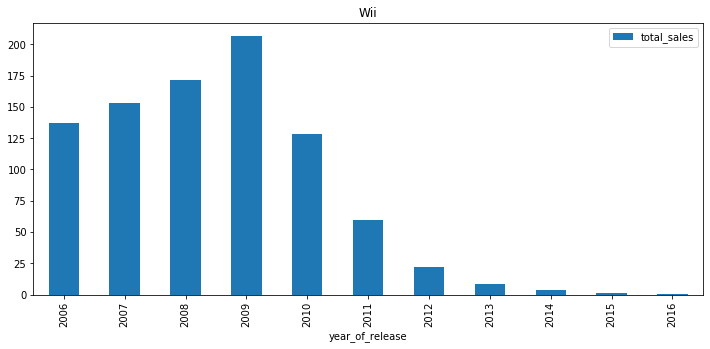

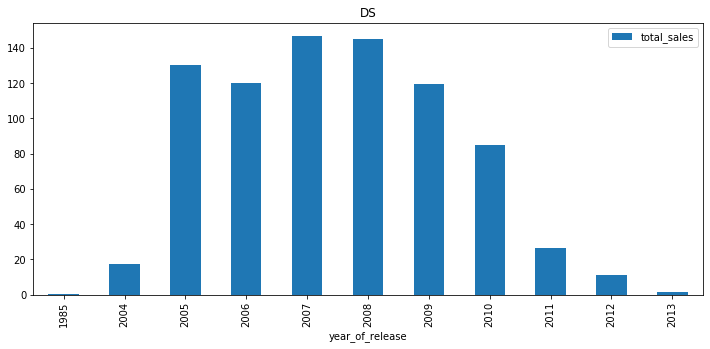

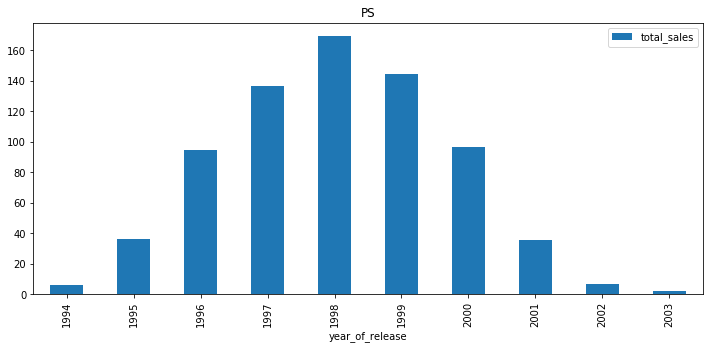

In [11]:
for platform in platforms_dict:
    data[data['platform'] == platform].pivot_table(index='year_of_release', 
                                                   values='total_sales', 
                                                   aggfunc='sum').plot(kind='bar', figsize=(12,5))
    plt.title(platform)

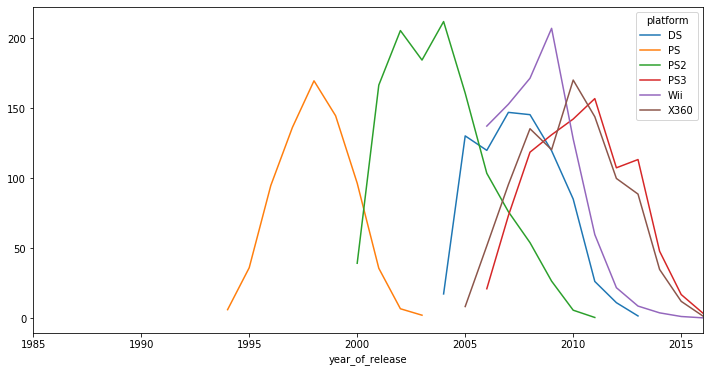

In [12]:
data.query('platform in @platforms_dict').pivot_table(index='year_of_release', 
                                                      columns = 'platform', 
                                                      values='total_sales', 
                                                      aggfunc='sum').plot(figsize=(12, 6))
plt.show()

#### В итоге, мы можем сказать, что платформы "живут" около 10-11 лет. 

#### На основе анализа, если брать основную цель прогноз на 2017 год, решено выбрать период с 2014 по 2016 года.

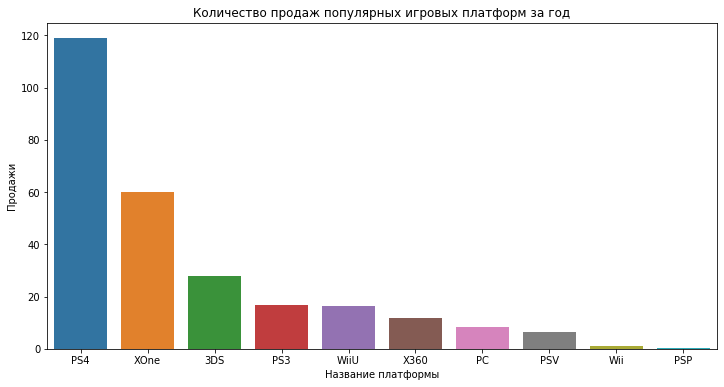

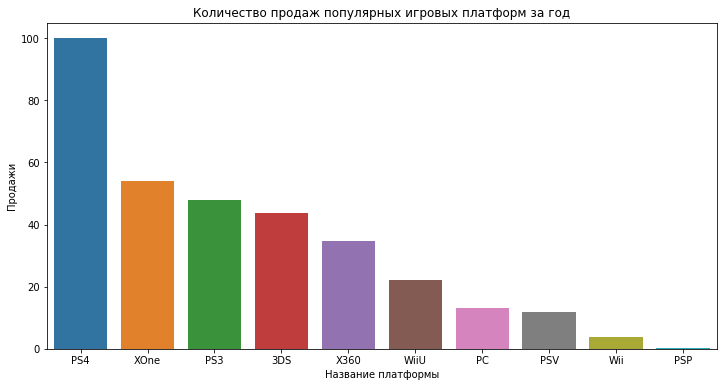

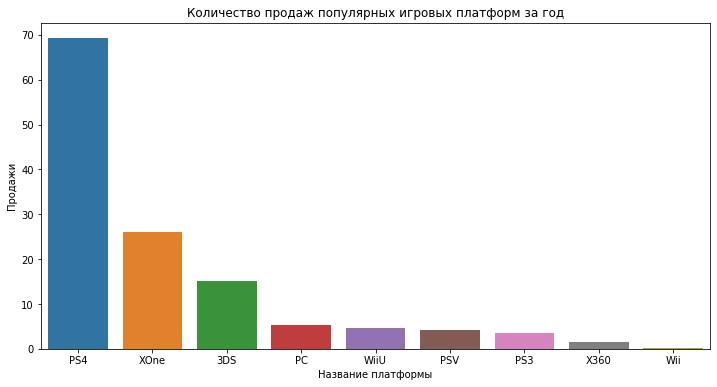

In [13]:
def graphic(actual_data):
    plt.figure(figsize=(12, 6))
    sns.barplot(data = actual_data, x='platform', y='total_sales')
    plt.title('Количество продаж популярных игровых платформ за год')
    plt.xlabel('Название платформы')
    plt.ylabel('Продажи')

actual_data = data.query('year_of_release >= 2014')
list_of_years = actual_data['year_of_release'].unique()
for years in list_of_years:
    actual_platform = actual_data[actual_data['year_of_release'] == years].pivot_table(
        index=['platform'],
        values='total_sales',
        aggfunc='sum').reset_index().sort_values(by='total_sales', ascending=False)
    graphic(actual_platform)

In [14]:
top_4 = actual_data.query('year_of_release == 2016')
top_4_platforms = top_4.pivot_table(index='platform', 
    values='total_sales', 
    aggfunc='sum').sort_values(by='total_sales', ascending=False).head(4)
top_4_platforms = top_4_platforms.reset_index().rename_axis(None, axis=1)
print(top_4_platforms)

  platform  total_sales
0      PS4        69.25
1     XOne        26.15
2      3DS        15.14
3       PC         5.25


In [15]:
data_top_4_platforms = data[data['platform'].isin(['PC','XOne','PS4','3DS'])]
data_top_4_platforms = data_top_4_platforms[data_top_4_platforms['total_sales']<1.5]

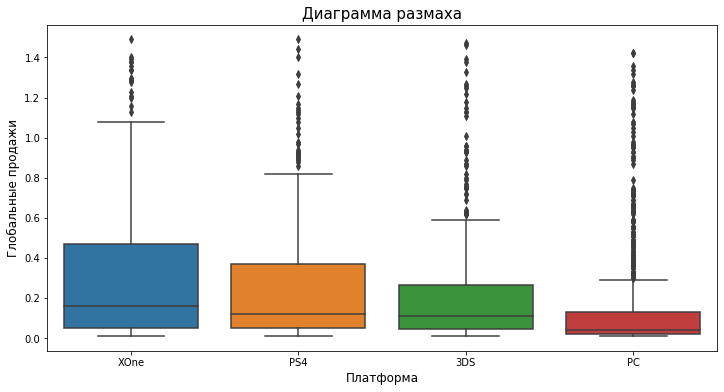

In [16]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data_top_4_platforms, x='platform', y='total_sales')
plt.title('Диаграмма размаха', fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Глобальные продажи',fontsize=12)
plt.show()

Исходя из графика, мы видим различие продаж, т.е. XOne самая продаваемая платформа, видим различие медиан среди наших платформ, а также можем заметить, единичные игры, которые выстреливают на той или иной платформе.

In [17]:
#Рассмотрим корреляцию между продажами и отзывами пользователей для платформы PS4
ps4 = actual_data[actual_data['platform'] == 'PS4']
ps4['user_score'].corr(ps4['total_sales'])
#ps4.info()

-0.040131589472697356

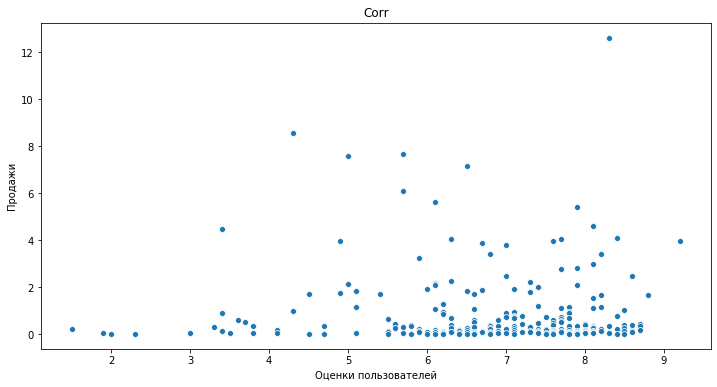

In [18]:
#Построим диаграмму рассеяния
plt.figure(figsize=(12,6))
sns.scatterplot(x='user_score', y='total_sales', data=ps4)
plt.title('Сorr')
plt.xlabel('Оценки пользователей')
plt.ylabel('Продажи')
plt.show()

Можно заметить, что зависимости между оценками пользователей и продажами игр на PS4 практически нету, но также надо брать в расчет, что у многих игр отсутствует оценка пользователей.

In [19]:
#Рассмотрим корреляцию между продажами и отзывами критиков для платформы PS4
ps4['critic_score'].corr(ps4['total_sales'])

0.40266141068104083

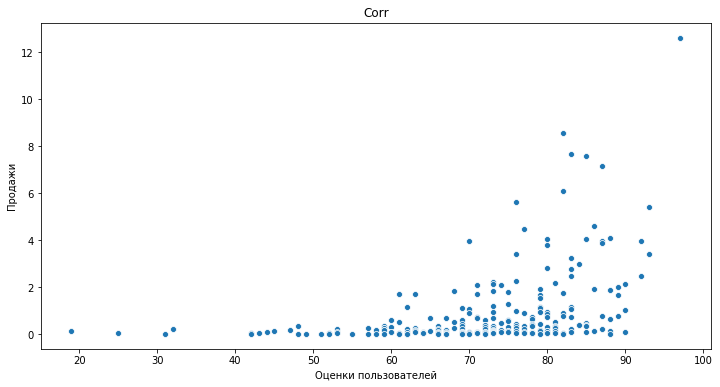

In [20]:
#Построим диаграмму рассеяния
plt.figure(figsize=(12,6))
sns.scatterplot(x='critic_score', y='total_sales', data=ps4)
plt.title('Сorr')
plt.xlabel('Оценки пользователей')
plt.ylabel('Продажи')
plt.show()

А оценки критиков уже довольно заметно влияют на продажи игр на платформе PS4.

In [21]:
def correlation(platform_name):
    platform = actual_data[actual_data['platform'] == platform_name]
    
    print('Коэффициент корреляции между отзывами пользователей и продажами =', platform['user_score'].corr(platform['total_sales']))
    plt.figure(figsize = (12,6))
    sns.scatterplot(x = 'user_score', y = 'total_sales', data = platform)
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Все продажи')
    plt.title('Диаграмма рассеяния между отзывами пользователей и продажами')

    print('Коэффициент корреляции между оценками критиков и продажами =', platform['critic_score'].corr(platform['total_sales']))
    plt.figure(figsize = (12,6))
    sns.scatterplot(x = 'critic_score', y = 'total_sales', data = platform)
    plt.xlabel('Оценка критиков')
    plt.ylabel('Все продажи')
    plt.title('Диаграмма рассеяния между оценками критиков и продажами')

Коэффициент корреляции между отзывами пользователей и продажами = -0.0703839280647581
Коэффициент корреляции между оценками критиков и продажами = 0.42867694370333226


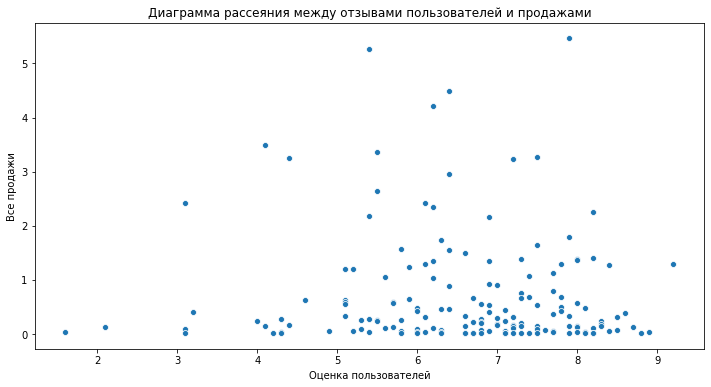

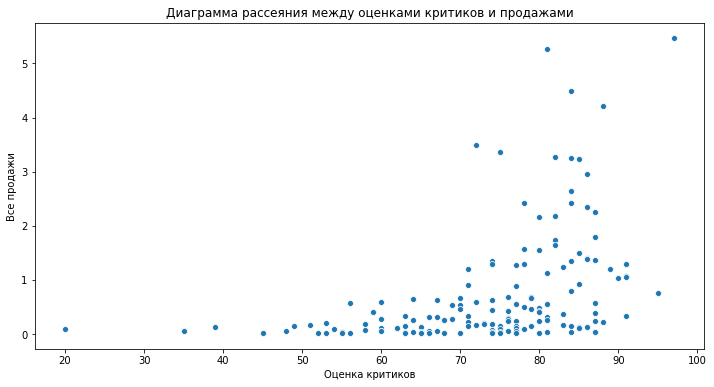

Коэффициент корреляции между отзывами пользователей и продажами = 0.2151932718527028
Коэффициент корреляции между оценками критиков и продажами = 0.314117492869051


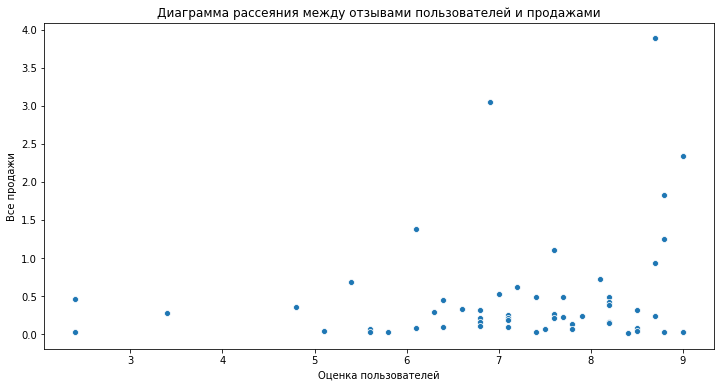

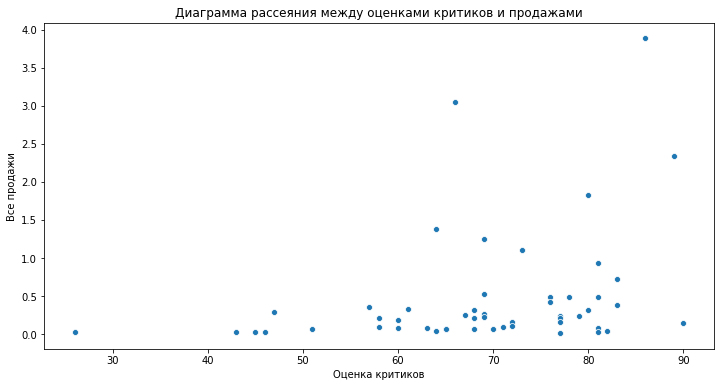

Коэффициент корреляции между отзывами пользователей и продажами = -0.07159665703472451
Коэффициент корреляции между оценками критиков и продажами = 0.17463413769350036


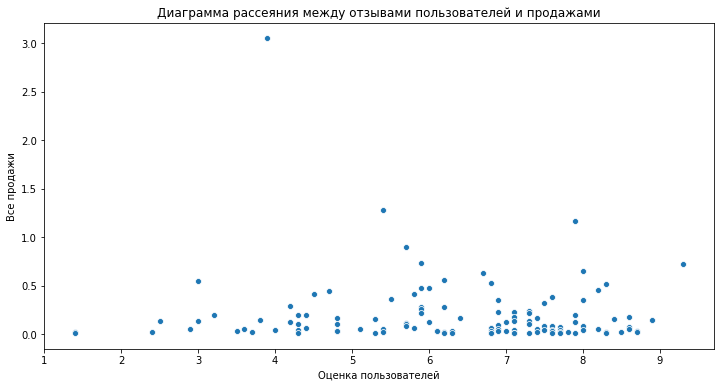

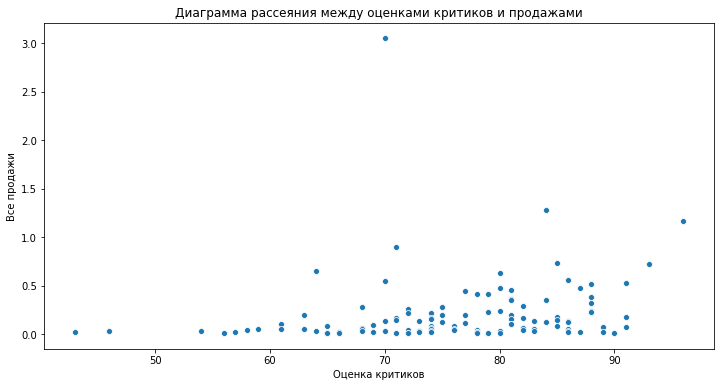

In [22]:
correlation('XOne')
plt.show()
correlation('3DS')
plt.show()
correlation('PC')

Можно сделать следующий вывод, что самая большая зависимость продажи игр от оценки критиков у PS4 и XOne. А среди всех 4-ех наших платформ отзывы пользователей больше всего влияют на платформу 3DS, но в целом, эти два критерия почти не взаимосвязны.

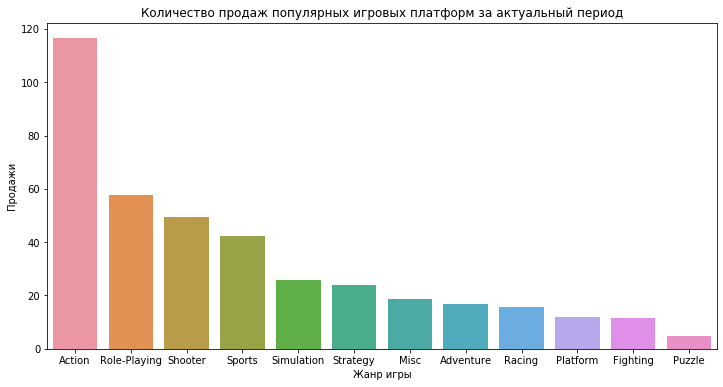

In [23]:
#Рассмотрим самые популярные жанры игр среди наших актуальных платформ.
actual_genre = data_top_4_platforms.pivot_table(index='genre', 
    values='total_sales', 
    aggfunc='sum').sort_values(by='total_sales', ascending=False).reset_index().rename_axis(None, axis=1)
#actual_genre
plt.figure(figsize=(12, 6))
sns.barplot(data = actual_genre, x='genre', y='total_sales')
plt.title('Количество продаж популярных игровых платформ за актуальный период')
plt.xlabel('Жанр игры')
plt.ylabel('Продажи')
plt.show()

По данному графику можно заметить, что 3 лидерующих жанра Action, Role-Playing и Shooter, в сумме игр этих жанров продано более 200 млн копий. А также Fighting и Puzzle совсем стали неинтересны. 

### Вывод

Из нашего исследовательского анализа можно сделать следующие выводы. В 80-ых и 90-ых годах выходило мало игр по сравнению с пиком, т.е. с 2000 года по 2010 год, после чего наблюдается спад выпускаемых игр. Выделили 4 самые популярные платформы за период 2014-2016гг: PS3, XOne, 3DS, PC. PC находится в этом списке, т.к. на него не действует смена поколений, и по сути данная платформа всегда будет актуальна. Мы узнали, что средняя "жизнь" платформ около 10 лет и пик продаж приходится на момент середины "жизни" приставки, т.е. спустя 5 лет она становится максимально популярной. Из диаграммы размаха можно сделать вывод, что большую прибыль дают конкретные игры, которые выстреливают, их продажи могут быть в 10-ки раз больше, чем у других игр. Следующий пункт, взаимосвязь между продажами и оценок пользователей и критиков. Исходя из анализа, наблюдаем, что у всех наших платформ заметна корреляция между продажами и оценками критиков, с оценками пользователей ситуация наоборот. Но можно подчеркнуть, что люди, которые пользуется 3DS, иногда опираются на мнение пользователей. В общем и целом, мнение критиков важнее мнения обычных пользователей. В заключении, мы выделили популярность игровых жанров, самыми популярными являются Action и Shooter, а на последнем месте "пылятся" Strategy и Puzzle.

## Портрет пользователя для каждого региона <a id="portrait"></a>

#### Составим портрет для региона NA, EU, JP.

##### Сравним топ 5 платформ в наших регионах

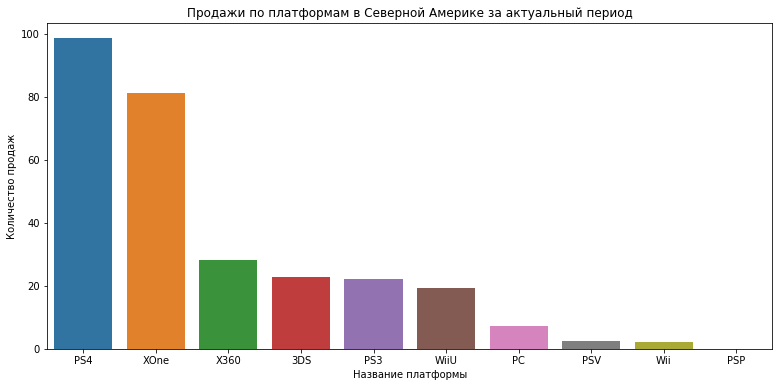

In [24]:
platform_sales_NA = actual_data.pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum').sort_values(by = 'na_sales', ascending = False)
plt.figure(figsize=(13,6))
sns.barplot(x=platform_sales_NA.index, y=platform_sales_NA['na_sales'])

plt.title("Продажи по платформам в Северной Америке за актуальный период")
plt.xlabel("Название платформы")
plt.ylabel("Количество продаж")
plt.show()

Топ 5 платформ в Северной Америке: PS4, XOne, X360, 3DS, PS3

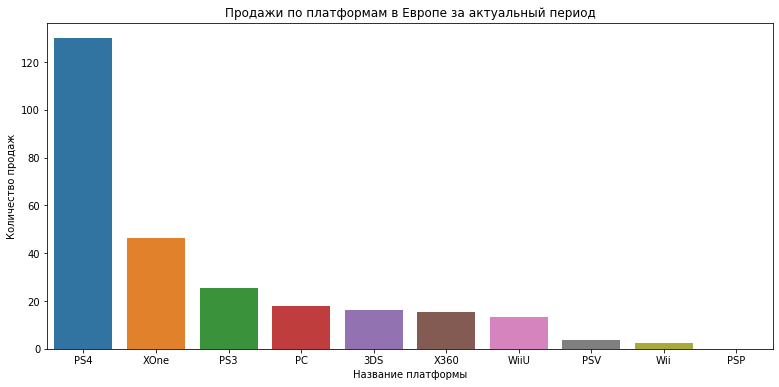

In [25]:
platform_sales_EU = actual_data.pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum').sort_values(by = 'eu_sales', ascending = False)
plt.figure(figsize=(13,6))
sns.barplot(x=platform_sales_EU.index, y=platform_sales_EU['eu_sales'])

plt.title("Продажи по платформам в Европе за актуальный период")
plt.xlabel("Название платформы")
plt.ylabel("Количество продаж")
plt.show()

Топ 5 платформ в Европе: PS4, XOne, PS3, PC, 3DS.

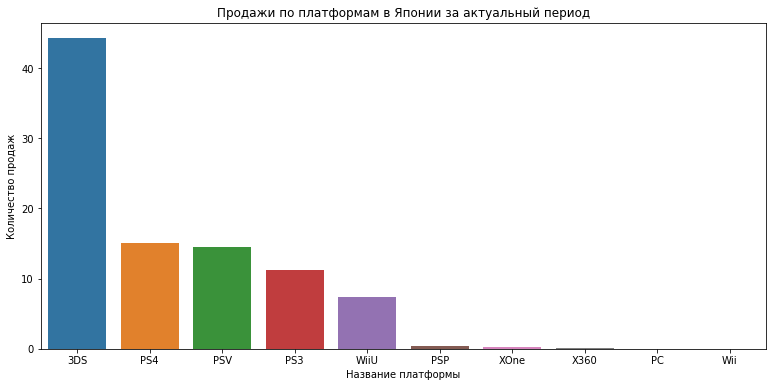

In [26]:
platform_sales_JP = actual_data.pivot_table(index = 'platform', values = 'jp_sales', aggfunc = 'sum').sort_values(by = 'jp_sales', ascending = False)
plt.figure(figsize=(13,6))
sns.barplot(x=platform_sales_JP.index, y=platform_sales_JP['jp_sales'])

plt.title("Продажи по платформам в Японии за актуальный период")
plt.xlabel("Название платформы")
plt.ylabel("Количество продаж")
plt.show()

Топ 5 платформ в Японии: 3DS, PS4, PSV, PS3, WiiU.

#### Картина следующая, топ 5 платформ в Северной Америке схожа с Европой, в этих регионах самыми популярными являются PS4 и XOne, а вот в Японии, видимо, поддерживают отечественный продукт и в основном пользуется 3DS.


##### Перейдем к жанрам

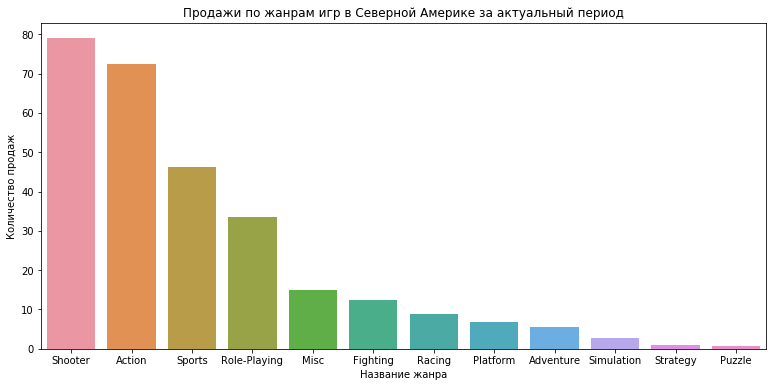

In [27]:
genre_sales_NA = actual_data.pivot_table(index = 'genre', values = 'na_sales', aggfunc = 'sum').sort_values(by = 'na_sales', ascending = False)
plt.figure(figsize=(13,6))
sns.barplot(x=genre_sales_NA.index, y=genre_sales_NA['na_sales'])

plt.title("Продажи по жанрам игр в Северной Америке за актуальный период")
plt.xlabel("Название жанра")
plt.ylabel("Количество продаж")
plt.show()

Топ 5 жанров в Северной Америке: Shooter, Action, Sports, Role-Playing, Misc.

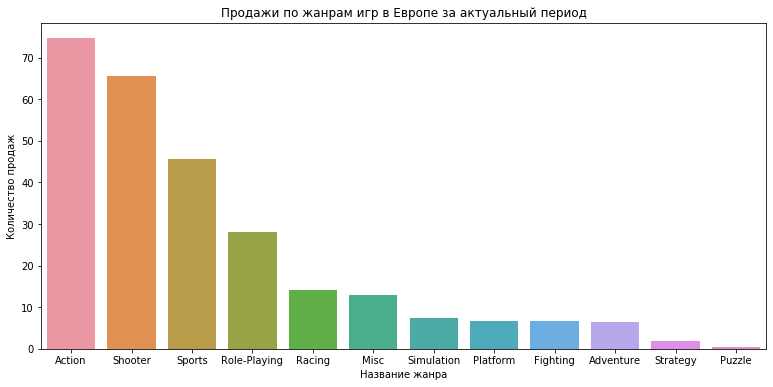

In [28]:
genre_sales_EU = actual_data.pivot_table(index = 'genre', values = 'eu_sales', aggfunc = 'sum').sort_values(by = 'eu_sales', ascending = False)
plt.figure(figsize=(13,6))
sns.barplot(x=genre_sales_EU.index, y=genre_sales_EU['eu_sales'])

plt.title("Продажи по жанрам игр в Европе за актуальный период")
plt.xlabel("Название жанра")
plt.ylabel("Количество продаж")
plt.show()

Топ 5 жанров в Европе: Action, Shooter, Sports, Role-Playing, Racing. 

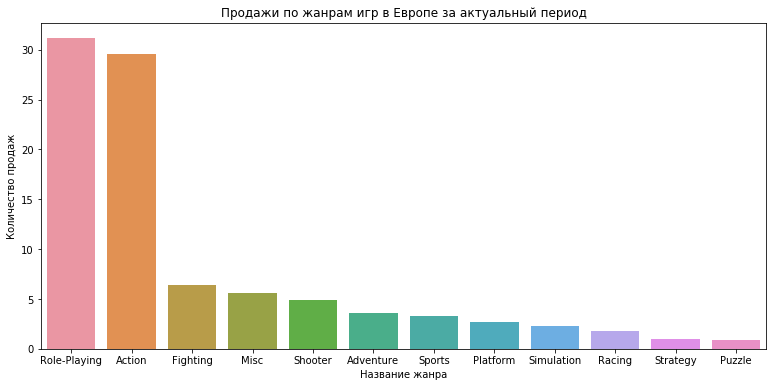

In [29]:
genre_sales_JP = actual_data.pivot_table(index = 'genre', values = 'jp_sales', aggfunc = 'sum').sort_values(by = 'jp_sales', ascending = False)
plt.figure(figsize=(13,6))
sns.barplot(x=genre_sales_JP.index, y=genre_sales_JP['jp_sales'])

plt.title("Продажи по жанрам игр в Европе за актуальный период")
plt.xlabel("Название жанра")
plt.ylabel("Количество продаж")
plt.show()

Топ 5 жанров в Японии: Role-Playing, Action, Fighting, Misc, Shooter.

#### Картина следующая, ведущие жанры игр схожи у Северной-Америки и Европы, их топ 3 занимают Action, Shooter и Sports. И снова Япония отличается от наших двух регионов, в этом регионе самый популярный жанр Role-Playing, а у двух других этот жанр на 4-ом месте, а топ 5 в Японии завершает жанр Shooter, который в Cеверной-Америке и Европе занимается топ 1-2.

##### И в конце, рассмотрим влияния рейтинга ESRB на продажи

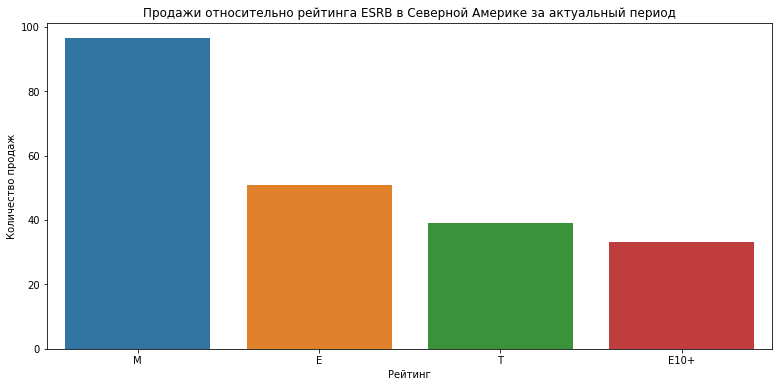

In [30]:
rating_sales_NA = actual_data.pivot_table(index = 'rating', values = 'na_sales', aggfunc = 'sum').sort_values(by = 'na_sales', ascending = False)
plt.figure(figsize=(13,6))
sns.barplot(x=rating_sales_NA.index, y=rating_sales_NA['na_sales'])

plt.title("Продажи относительно рейтинга ESRB в Северной Америке за актуальный период")
plt.xlabel("Рейтинг")
plt.ylabel("Количество продаж")
plt.show()

Особо активно продаются в Северной Америке игры с рейтингом M.

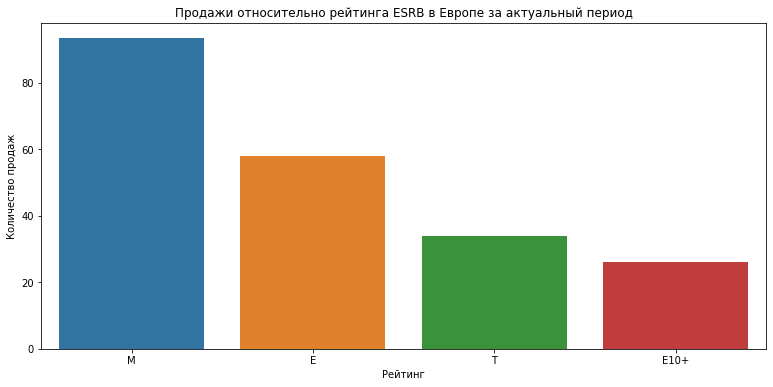

In [31]:
rating_sales_EU = actual_data.pivot_table(index = 'rating', values = 'eu_sales', aggfunc = 'sum').sort_values(by = 'eu_sales', ascending = False)
plt.figure(figsize=(13,6))
sns.barplot(x=rating_sales_EU.index, y=rating_sales_EU['eu_sales'])

plt.title("Продажи относительно рейтинга ESRB в Европе за актуальный период")
plt.xlabel("Рейтинг")
plt.ylabel("Количество продаж")
plt.show()

В Европе индентичная ситуация относительно Северной Америки.

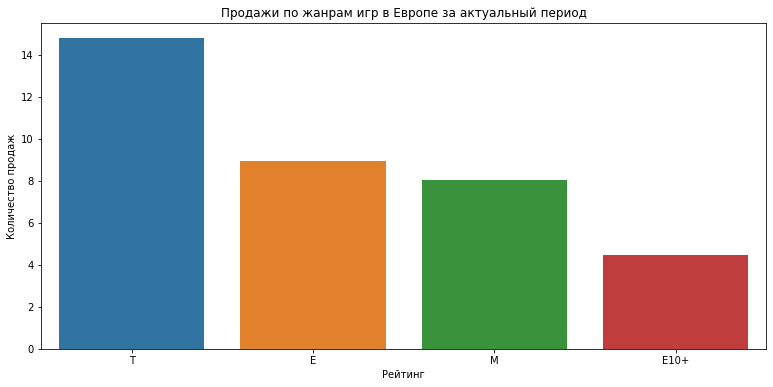

In [32]:
rating_sales_JP = actual_data.pivot_table(index = 'rating', values = 'jp_sales', aggfunc = 'sum').sort_values(by = 'jp_sales', ascending = False)
plt.figure(figsize=(13,6))
sns.barplot(x=rating_sales_JP.index, y=rating_sales_JP['jp_sales'])

plt.title("Продажи по жанрам игр в Европе за актуальный период")
plt.xlabel("Рейтинг")
plt.ylabel("Количество продаж")
plt.show()

И как всегда Япония отличается от других регионов, тут преобладают игры с рейтингом T, но на последнем месте также игры с рейтингом E10+.

In [33]:
region = ['na_sales', 'eu_sales', 'jp_sales']
def graphic_region(region):
    for i in region:
        platform_sales = actual_data.pivot_table(
        index = 'platform',
        values = i,
        aggfunc = 'sum').sort_values(by = i, ascending = False)

        plt.figure(figsize=(13,6))
        sns.barplot(x=platform_sales.index, y=platform_sales[i])
        plt.title("Продажи по региону за актуальный период")
        plt.xlabel("Название платформы")
        plt.ylabel("Количество продаж")

        genre_sales = actual_data.pivot_table(
            index = 'genre',
            values = i,
            aggfunc = 'sum').sort_values(by = i, ascending = False)

        plt.figure(figsize=(13,6))
        sns.barplot(x=genre_sales.index, y=genre_sales[i])

        plt.title("Продажи по жанрам за актуальный период")
        plt.xlabel("Название жанра")
        plt.ylabel("Количество продаж")


        rating_sales = actual_data.pivot_table(
            index = 'rating',
            values = i,
            aggfunc = 'sum').sort_values(by = i, ascending = False)

        plt.figure(figsize=(13,6))
        sns.barplot(x=rating_sales.index, y=rating_sales[i])

        plt.title("Продажи по рейтингу за актуальный период")
        plt.xlabel("Рейтинг")
        plt.ylabel("Количество продаж")

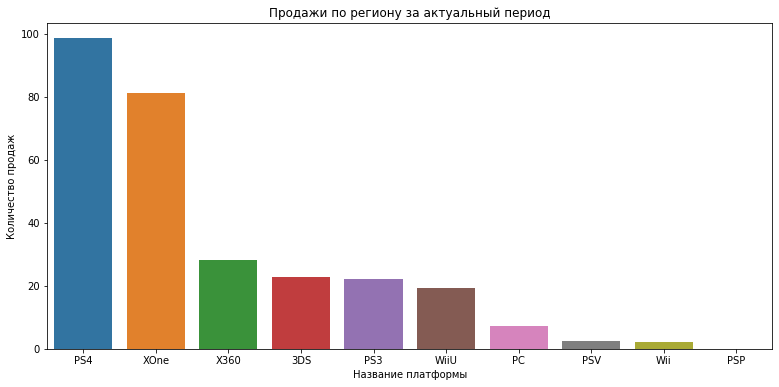

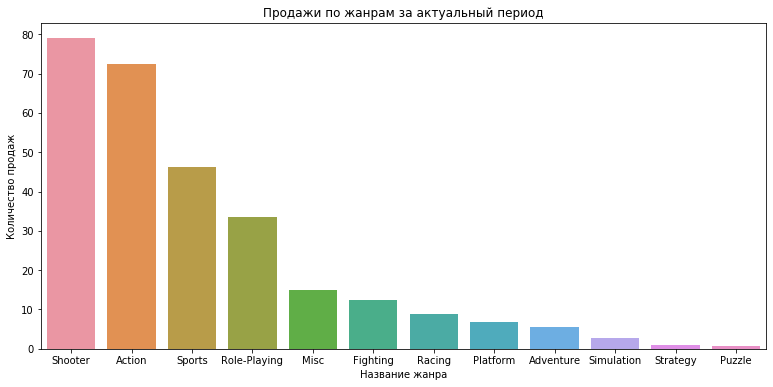

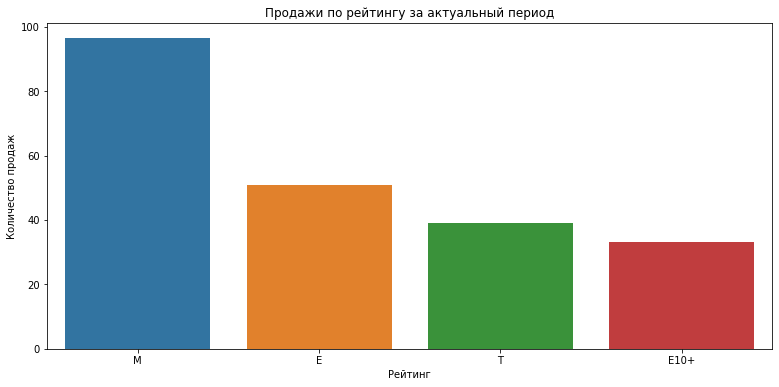

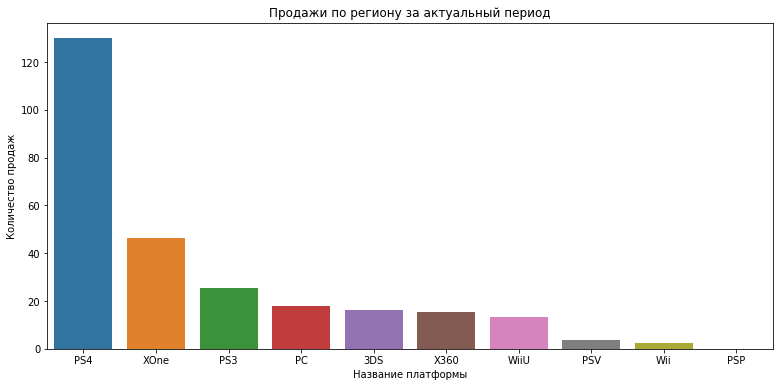

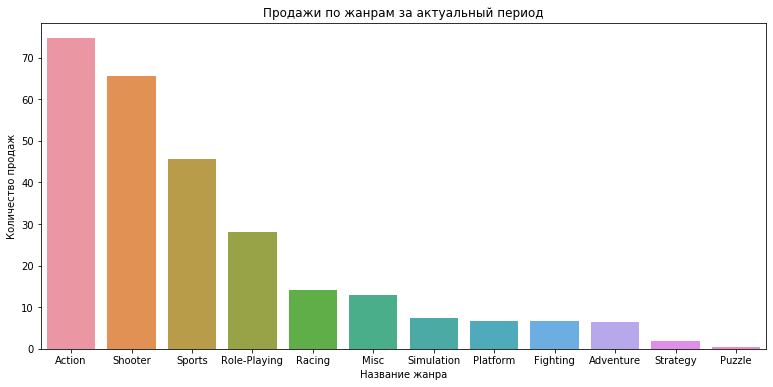

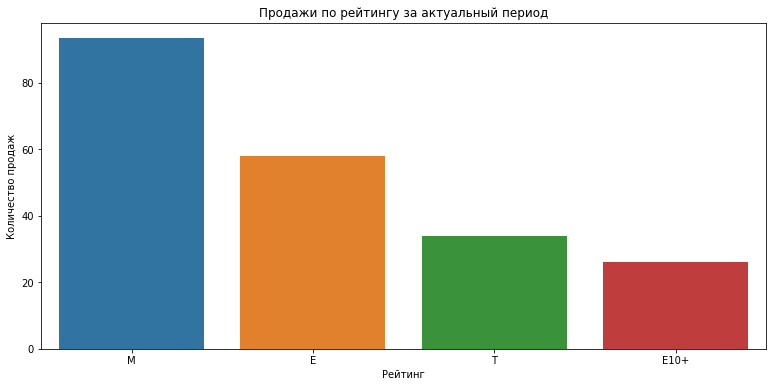

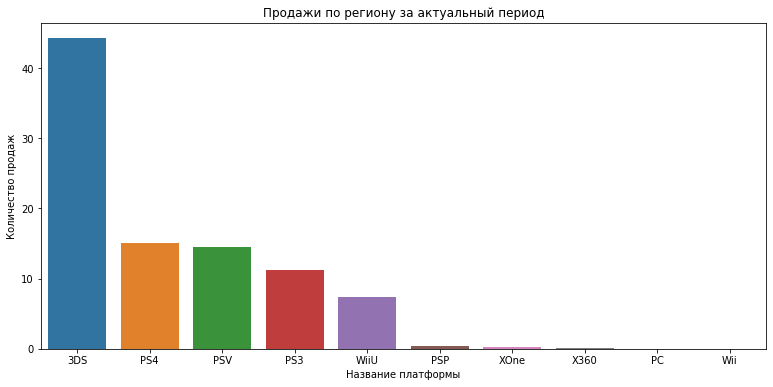

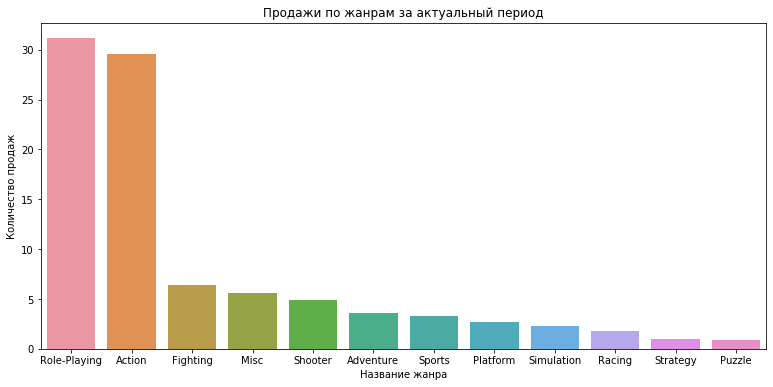

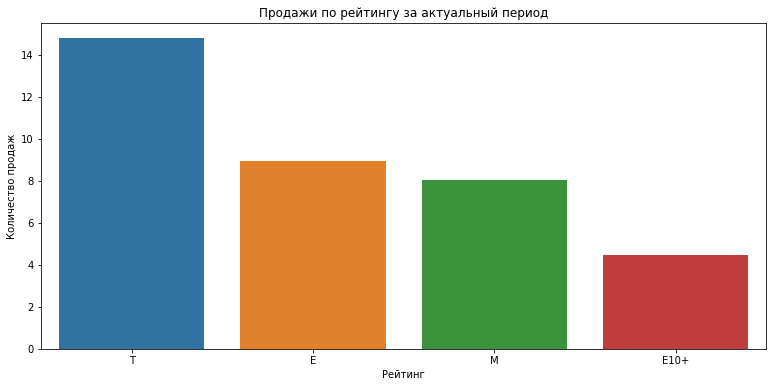

In [34]:
graphic_region(region)

### Вывод

Особо популярными платформами для игр в Северной Америке являеются PS4 и XOne. В Европе схожая картина, но PS4 еще более популярна чем в Америке. А если рассмотреть Японии, то там самая популярная платформа - 3DS, не смотря на то, что эта платформа преодолела свой пик общих продаж, из этого можно сделать вывод, что в Японии продвигают отечественную продукцию. Самый популярные жанры игр в Европе и Северной Америке является Action и Shooter, а в Японии Action также популярен, но первое место занимает жанр Role-Playing. В Европе и Северной Америке больше всего продается игр для взрослой аудитории, а в Японии для подростков. Такую тенденцию можно объяснить, как обычную популярность игр с конкретным рейтингом, либо из-за условий приобретении игр.

## Проверка гипотез <a id="hypothesis"></a>

#### Перейдем к проверке гипотез.

1. Средние пользовательские рейтинги платформ XOne и PC одинаковые.

H₀: Средние пользовательские рейтинги платформ XOne и PC одинаковые;

H₁: Средние пользовательские рейтинги платформ XOne и PC различаются.

In [35]:
xbox_rating = actual_data[actual_data['platform'] == 'XOne']['user_score']
PC_rating = actual_data[actual_data['platform'] == 'PC']['user_score']
alpha = .01

results = st.ttest_ind(xbox_rating.dropna(),PC_rating.dropna(),equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11601398086668827
Не получилось отвергнуть нулевую гипотезу


Отсюда делаем вывод, что средние пользовательские рейтинги у XOne и PC особо не различаются.

2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

H₀: Рейтинги жанров Action и Sports одинаковые;

H₁: Рейтинги жанров Action и Sports разные.

In [36]:
action_rating = actual_data[actual_data['genre'] == 'Action']['user_score']
sports_rating = actual_data[actual_data['genre'] == 'Sports']['user_score']
alpha = .01

results = st.ttest_ind(action_rating.dropna(),sports_rating.dropna(),equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


Следовательно, средние пользовательские рейтинги жанров Action и Sports разные.

### Вывод

В итоге мы проверили две следующий гипотезы: 1. Средние пользовательские рейтинги платформ XOne и PC одинаковые и 2. Средние пользовательские рейтинги жанров Action и Sports разные. В первом случае, мы не смогли отвергнуть нулевую гипотезу и делаем вывод, что средние пользовательские рейтинги у XOne и PC не различаются. А во-втором, мы отвергли нулевую гипотезу и сделали вывод, что средние пользовательские рейтинги жанров Action и Sports разные.

## Общий вывод <a id="conclusion"></a>

В данной работе мы рассматривали базу данных, основанную на информации о играх, их платформах и т.д. Изначально, мы оценили весь датасет, чтобы оценить возможные ошибки в данных. Следующим шагом, след-но, мы подготовили наши данные, привели к нижнему регистру названия столбцов, изменили тип данных на более корректные и убрали две строки, в которых пропущены названия игры, а также заменили tbd, что значит данные, которые специально не заполнили, на NaN. И в конце подготовки данных добавили столбец, который отражает общие продажи игр по 3-ем регионам. Переходим к исследовательскому анализу, из него мы выяснили, что больше всего выпущено игр было с 2002 по 2012 год. Также определили "жизнь" платформы, которая составляет 10 лет и пик продаж игр на платформе составлет примерно 5 лет спустя её выхода. Далее, выявили актуальный период с 2014 по 2016 год. Основным фактором являлось построение прогноза на 2017 год. Также, выделили 4 самые прибыльные платформы за наш актуальный период, теперь в работе мы будем использовать только его, это PS4, XOne, 3DS и PC. Компьютеры выбраны в данную 4-ку, т.к. они живут на протяжении большего промежутка времени и их почти невозможно заменить, поэтому они в любой момент могут стать намного прибыльней, чем другие платформы. Мы рассмотрели, как влияют оценки пользователей и критиков на продажи внутри наших платформ. Оценка критиков имеет влияние на продажи для всех платформ, а оценка пользователей не особо, хотя обладатели 3DS, чаще других прислушиваются к мнению пользователей. И в конце нашего анализа, определили самые прибыльные жанры игр. Самые прибыльные: Action и Shooter, а в самых низах таятся Puzzle и Strategy. Затем, мы построили портрет пользователя для каждого региона. В Северной Америке пользователь, скорее всего, выберет платформу PS4 или XOne, также выберет жанр Action или Shooter и играет в игры с взрослым рейтингом. В Европе, примерно, такая же ситуация, но PS4 еще более популярна. А в Японии все иначе, пользователь с большей вероятностью играет в игры для подростков на платформе 3DS и предпочитает игры жанра Role-playing или Action. Отсюда, можем сделать вывод, что если игра выйдет на PS4, будет жанра Action и рейтинг игры ESRB будет для людей старше 17 лет, то она будет особо прибыльной. И в конце мы проверили 2 гипотезы, из которых сделали выводы. Первый вывод: cредние пользовательские рейтинги у XOne и PC особо не различаются. Второй вывод: средние пользовательские рейтинги жанров Action и Sports разные.